In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [20]:
interval = '0.001H'  # Точечный
# interval = '1H'

In [21]:
df = pd.read_csv('metrics_collector.tsv', sep='\t', header=None)

C:\Users\Lizik\AppData\Local\Temp\ipykernel_19856\750769984.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('metrics_collector.tsv', sep='\t', header=None)


In [22]:
df.columns = [
	'account_id',
	'name',
	'point',
	'call_count',
	'total_call_time',
	'total_exclusive_time',
	'min_call_time',
	'max_call_time',
	'sum_of_squares',
	'instances',
	'language',
	'app_name',
	'app_id',
	'scope',
	'host',
	'display_host',
	'pid',
	'agent_version',
	'labels',
]

In [26]:
# Get information about the DataFrame
df.describe()

account_id    call_count  total_call_time  total_exclusive_time  \
count  18363750.0  1.836375e+07     1.836375e+07          1.836375e+07   
mean          1.0  2.782507e+02     1.099198e+04          6.331889e+03   
std           0.0  9.276939e+02     2.666378e+05          2.588279e+05   
min           1.0  0.000000e+00     0.000000e+00          0.000000e+00   
25%           1.0  1.000000e+00     0.000000e+00          0.000000e+00   
50%           1.0  2.000000e+00     4.000000e-03          4.000000e-03   
75%           1.0  1.700000e+01     1.170693e+00          1.115517e+00   
max           1.0  3.234600e+04     5.295675e+08          5.295675e+08   

       min_call_time  max_call_time  sum_of_squares     instances  \
count   1.836375e+07   1.836375e+07    1.836375e+07  1.836375e+07   
mean    1.547996e+03   1.812189e+03    1.142497e+10  9.866087e-01   
std     3.665872e+04   1.578139e+05    1.330169e+13  8.187102e-02   
min     0.000000e+00   0.000000e+00    0.000000e+00  6.666667e-02   
25%     0.000000e+00   0.000000e+00    0.000000e+00  1.000000e+00   
50%     1.190360e-04   3.973580e-03    1.737977e-06  1.000000e+00   
75%     5.000000e-01   1.000000e+00    1.000000e+00  1.000000e+00   
max     1.604956e+06   1.578018e+08    3.149387e+16  1.333333e+00   

             app_id         pid  
count  1.836375e+07  18363750.0  
mean   1.759219e+13         1.0  
std    7.695313e-01         0.0  
min    1.759219e+13         1.0  
25%    1.759219e+13         1.0  
50%    1.759219e+13         1.0  
75%    1.759219e+13         1.0  
max    1.759219e+13         1.0

In [48]:
df_text = [
	'name',
	'point',
	'total_call_time',
	'language',
	'app_name',
	'app_id',
	'scope',
	'host',
	'display_host',
	'pid',
	'agent_version',
	'labels',
]

for colomn in df_text:
	print(colomn)
	print(df[colomn].unique()[:7])

name
['AgentCheck/CircuitBreaker/tripped/all' 'Apdex' 'CPU/User Time'
 'Datastore/operation/Redis/append' 'Datastore/operation/Redis/expire'
 'Datastore/Redis/all' 'Datastore/operation/Redis/get']
point
['2024-04-15 23:32:00' '2024-04-15 23:33:00' '2024-04-15 23:34:00'
 '2024-04-15 23:35:00' '2024-04-15 23:36:00' '2024-04-15 23:37:00'
 '2024-04-15 23:38:00']
total_call_time
[0.  1.5 0.5 2.  2.5 1.  4. ]
language
['java']
app_name
['[GMonit] Collector']
app_id
[17592186045423]
scope
[nan 'WebTransaction/Handler/apm/method/span_event_data'
 'WebTransaction/Handler/apm/method/analytic_event_data'
 'WebTransaction/Handler/apm/method/error_data'
 'WebTransaction/Handler/apm/method/metric_data'
 'WebTransaction/Handler/apm/method/transaction_sample_data'
 'WebTransaction/Handler/browser/1/:license-key']
host
['575f5ba20b4b' '7d30f074a8d0']
display_host
['575f5ba20b4b' '7d30f074a8d0']
pid
[1]
agent_version
['8.5.0' '8.7.0']
labels
['{}']


In [49]:
df_metrics = pd.DataFrame()

In [50]:
df_cr = df.copy()

In [51]:
df_WR = df_cr[['point', 'total_call_time', 'call_count']][
	(df_cr['language'] == 'java')
	& (df_cr['app_name'] == '[GMonit] Collector')
	& (df_cr['scope'].isnull())
	& (df_cr['name'] == 'HttpDispatcher')
]

In [52]:
df_webr = (
	df_WR.groupby('point')
	.agg(
		{
			'total_call_time': lambda x: np.nan if x.isna().all() else x.sum(),
			'call_count': lambda x: np.nan if x.isna().all() else x.sum(),
		}
	)
	.reset_index()
)
df_webr['y'] = df_webr['total_call_time'] / df_webr['call_count']

In [53]:
df_webr['webr_y'] = df_webr['y'] * 1000
df_webr['point'] = pd.to_datetime(df_webr['point'])
df_webr.set_index('point', inplace=True)
grouped_webr = df_webr.groupby(pd.Grouper(freq=interval)).mean().reset_index()
grouped_webr = grouped_webr[['point', 'webr_y']]

C:\Users\Lizik\AppData\Local\Temp\ipykernel_19856\1240464650.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  grouped_webr = df_webr.groupby(pd.Grouper(freq=interval)).mean().reset_index()


Text(0, 0.5, 'Задержка (ms)')

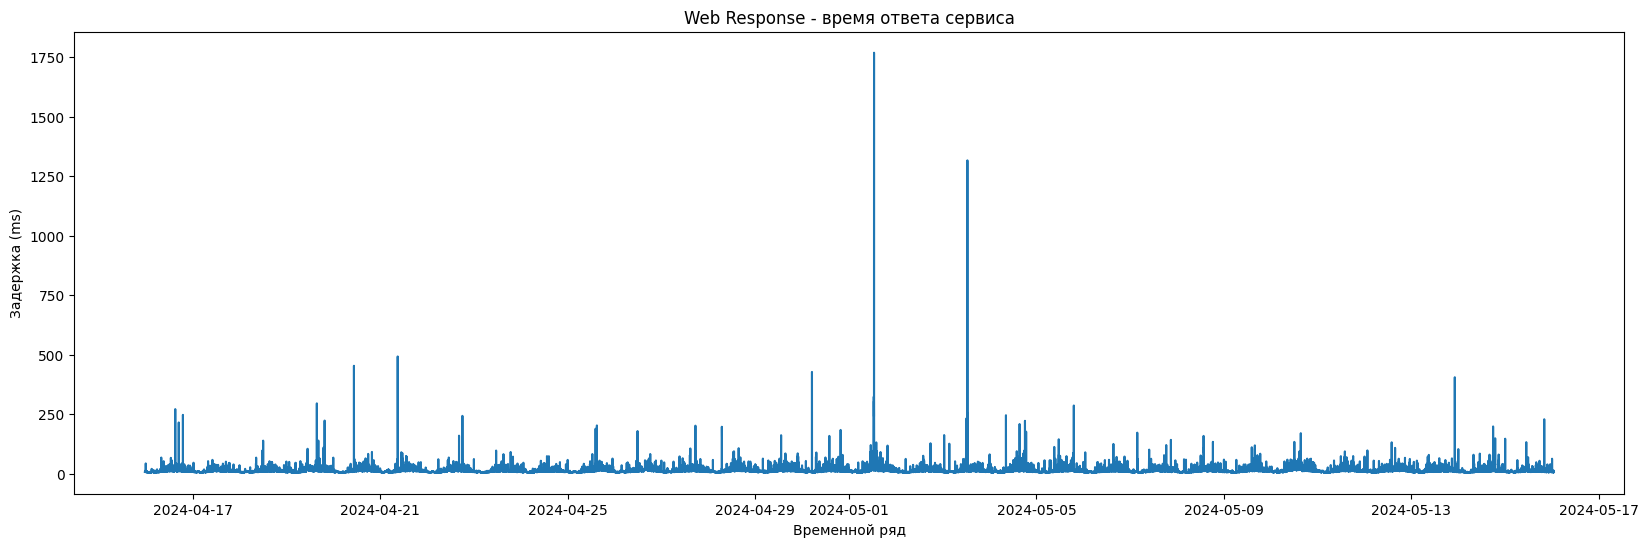

In [54]:
plt.figure(figsize=(20, 6))
sns.lineplot(x='point', y='webr_y', data=grouped_webr[['point', 'webr_y']])
plt.title('Web Response - время ответа сервиса')
plt.xlabel('Временной ряд')
plt.ylabel('Задержка (ms)')

In [55]:
df_T = df_cr[['point', 'call_count']][
	(df_cr['language'] == 'java')
	& (df_cr['app_name'] == '[GMonit] Collector')
	& (df_cr['scope'].isnull())
	& (df_cr['name'] == 'HttpDispatcher')
].fillna(0)

In [56]:
df_Tr = (
	df_T.groupby('point')
	.agg({'call_count': lambda x: np.nan if x.isna().all() else x.sum()})
	.reset_index()
)

In [57]:
df_Tr['point'] = pd.to_datetime(df_Tr['point'])
df_Tr.set_index('point', inplace=True)
df_Tr['Tr_y'] = df_Tr['call_count']

grouped_Tr = df_Tr.groupby(pd.Grouper(freq=interval)).mean().reset_index()
grouped_Tr = grouped_Tr[['point', 'Tr_y']]

C:\Users\Lizik\AppData\Local\Temp\ipykernel_19856\2488668987.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  grouped_Tr = df_Tr.groupby(pd.Grouper(freq=interval)).mean().reset_index()


Text(0, 0.5, 'RPM (запросы в минуту)')

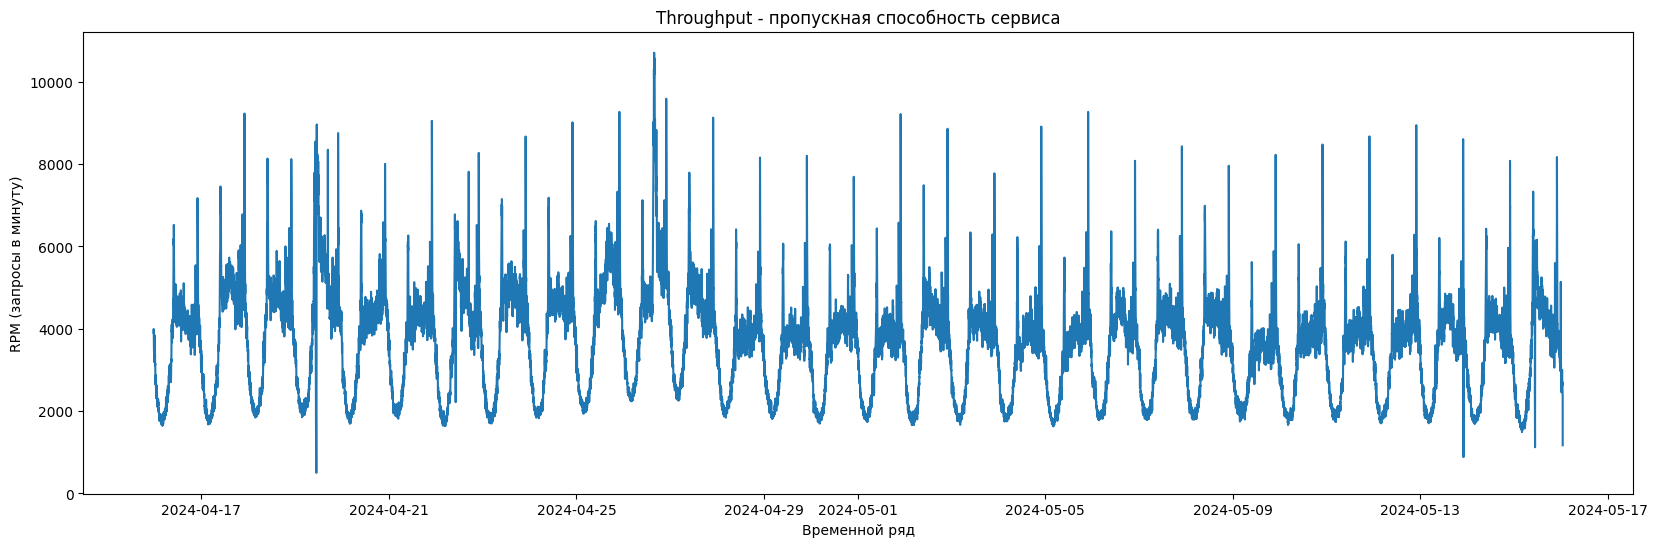

In [58]:
plt.figure(figsize=(20, 6))
sns.lineplot(x='point', y='Tr_y', data=grouped_Tr[['point', 'Tr_y']])
plt.title('Throughput - пропускная способность сервиса')
plt.xlabel('Временной ряд')
plt.ylabel('RPM (запросы в минуту)')

In [59]:
df_A = df_cr[['point', 'call_count', 'total_call_time', 'total_exclusive_time']][
	(df_cr['language'] == 'java')
	& (df_cr['app_name'] == '[GMonit] Collector')
	& (df_cr['scope'].isnull())
	& (df_cr['name'] == 'Apdex')
].fillna(0)

In [60]:
df_Ar = (
	df_A.groupby('point')
	.agg(
		{
			'total_exclusive_time': lambda x: np.nan if x.isna().all() else x.sum(),
			'total_call_time': lambda x: np.nan if x.isna().all() else x.sum(),
			'call_count': lambda x: np.nan if x.isna().all() else x.sum(),
		}
	)
	.reset_index()
)

In [61]:
df_Ar['Ar_y'] = (df_Ar['call_count'] + df_Ar['total_call_time'] / 2) / (
	df_Ar['call_count'] + df_Ar['total_call_time'] + df_Ar['total_exclusive_time']
)
df_Ar['point'] = pd.to_datetime(df_Ar['point'])
df_Ar.set_index('point', inplace=True)

grouped_Ar = df_Ar.groupby(pd.Grouper(freq=interval)).max().reset_index()
grouped_Ar = grouped_Ar[['point', 'Ar_y']]

C:\Users\Lizik\AppData\Local\Temp\ipykernel_19856\2089170517.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  grouped_Ar = df_Ar.groupby(pd.Grouper(freq=interval)).max().reset_index()


Text(0, 0.5, 'Показатель здоровья')

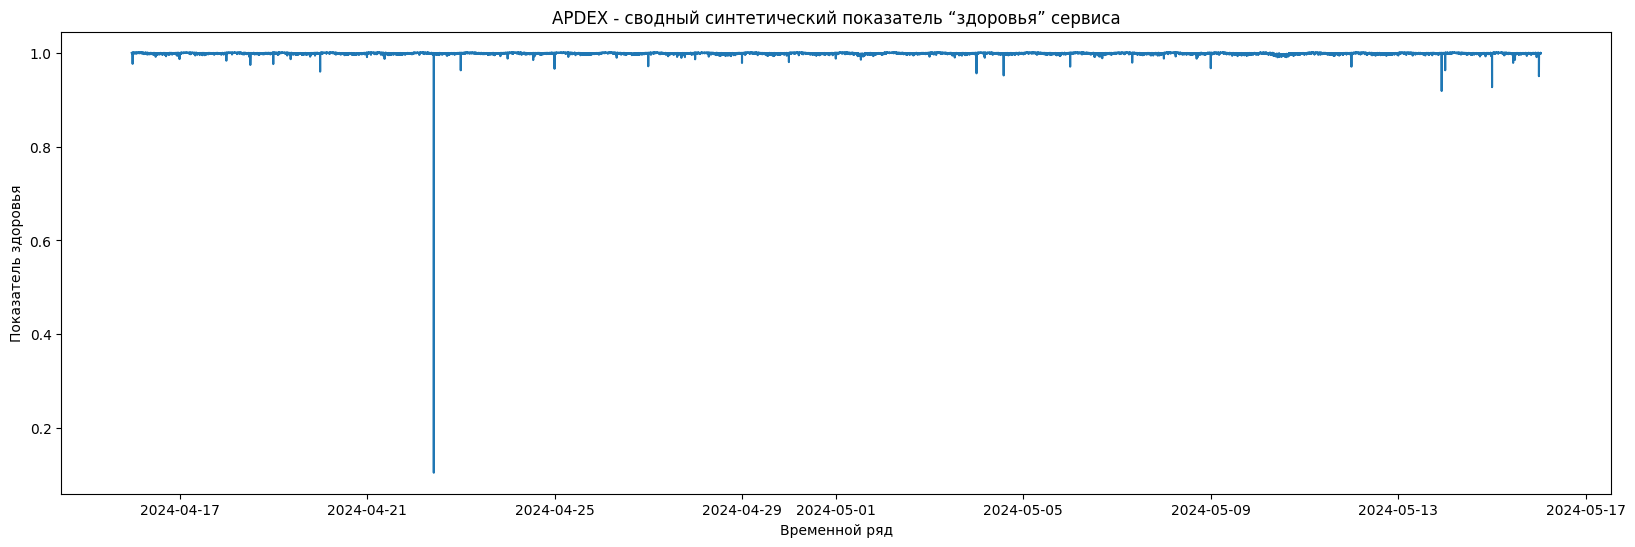

In [62]:
plt.figure(figsize=(20, 6))
sns.lineplot(x='point', y='Ar_y', data=grouped_Ar[['point', 'Ar_y']])
plt.title('APDEX - сводный синтетический показатель “здоровья” сервиса')
plt.xlabel('Временной ряд')
plt.ylabel('Показатель здоровья')

In [63]:
df_E = df_cr[['point', 'call_count', 'total_call_time', 'name']][
	(df_cr['language'] == 'java')
	& (df_cr['app_name'] == '[GMonit] Collector')
	& (df_cr['scope'].isnull())
	& (df_cr['name'].isin(['HttpDispatcher', 'Errors/allWeb']))
].fillna(0)

In [64]:
def sum_or_null_if(df, condition):
	filtered = df[condition]
	if filtered['call_count'].isna().all():
		return np.nan
	return filtered['call_count'].sum()


grouped = df_E.groupby('point')

results = grouped.apply(
	lambda x: pd.Series(
		{
			' ': sum_or_null_if(x, x['name'] == 'Errors/allWeb')
			/ sum_or_null_if(x, x['name'] == 'HttpDispatcher')
		}
	)
)
results

C:\Users\Lizik\AppData\Local\Temp\ipykernel_19856\2121819445.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = grouped.apply(lambda x: pd.Series({


point                        
2024-04-15 23:32:00  0.000128
2024-04-15 23:33:00  0.000128
2024-04-15 23:34:00       NaN
2024-04-15 23:35:00       NaN
2024-04-15 23:36:00       NaN
...                       ...
2024-05-16 00:54:00       NaN
2024-05-16 00:55:00       NaN
2024-05-16 00:56:00  0.000206
2024-05-16 00:57:00  0.000211
2024-05-16 00:58:00       NaN

[43272 rows x 1 columns]

In [22]:
df_Er = results.copy()

In [23]:
df_Er = df_Er.reset_index()
df_Er[['point', 'Er_y']] = df_Er
df_Er = df_Er[['point', 'Er_y']]
df_Er['point'] = pd.to_datetime(df_Er['point'])
df_Er.set_index('point', inplace=True)

In [24]:
grouped_Er = df_Er.groupby(pd.Grouper(freq=interval)).mean().reset_index()
grouped_Er = grouped_Er[['point', 'Er_y']]

C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Процент ошибок')

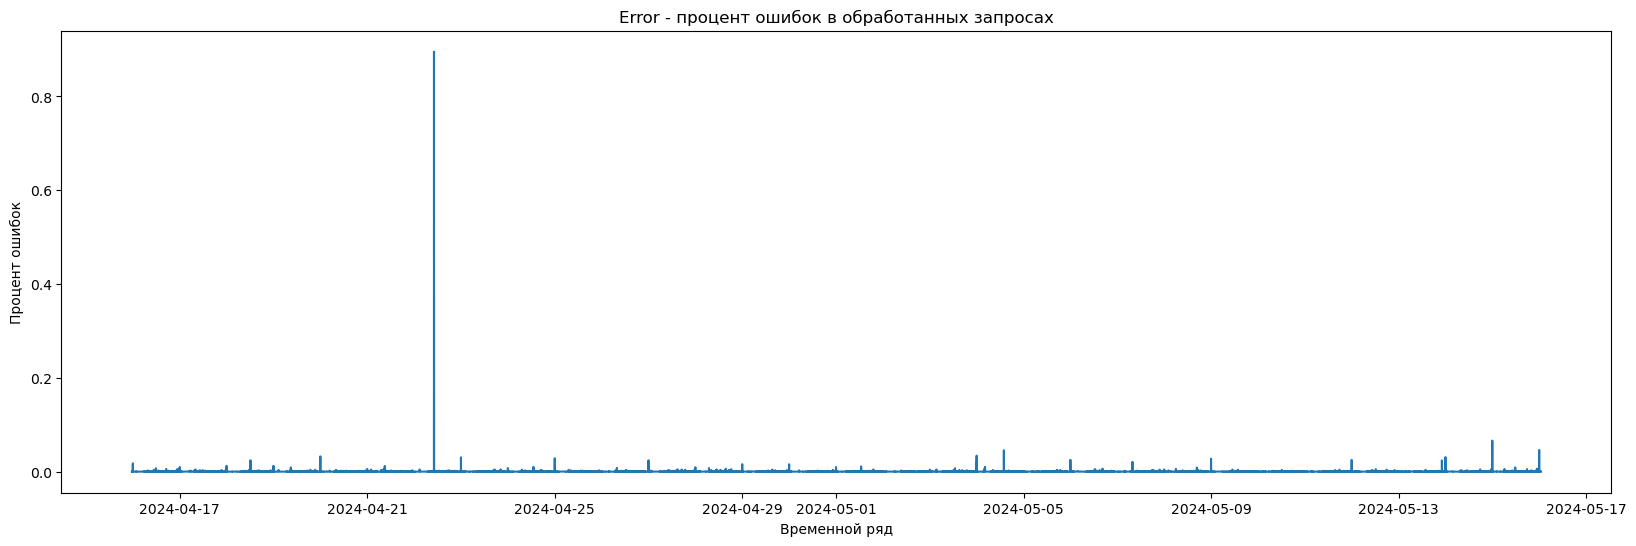

In [25]:
plt.figure(figsize=(20, 6))
sns.lineplot(x='point', y='Er_y', data=grouped_Er[['point', 'Er_y']])
plt.title('Error - процент ошибок в обработанных запросах')
plt.xlabel('Временной ряд')
plt.ylabel('Процент ошибок')

In [26]:
df_metrics = pd.concat(objs=[grouped_webr, grouped_Tr, grouped_Ar, grouped_Er], axis=1)

In [27]:
df_metrics = df_metrics.loc[:, ~df_metrics.columns.duplicated()]
df_metrics

point    webr_y    Tr_y      Ar_y      Er_y
0      2024-04-15 23:31:58.800  7.721694  3898.0  0.999679  0.000128
1      2024-04-15 23:32:02.400       NaN     NaN       NaN       NaN
2      2024-04-15 23:32:06.000       NaN     NaN       NaN       NaN
3      2024-04-15 23:32:09.600       NaN     NaN       NaN       NaN
4      2024-04-15 23:32:13.200       NaN     NaN       NaN       NaN
...                        ...       ...     ...       ...       ...
721429 2024-05-16 00:57:43.200       NaN     NaN       NaN       NaN
721430 2024-05-16 00:57:46.800       NaN     NaN       NaN       NaN
721431 2024-05-16 00:57:50.400       NaN     NaN       NaN       NaN
721432 2024-05-16 00:57:54.000       NaN     NaN       NaN       NaN
721433 2024-05-16 00:57:57.600  7.972579  1170.0  0.999145       NaN

[721434 rows x 5 columns]

<Axes: >

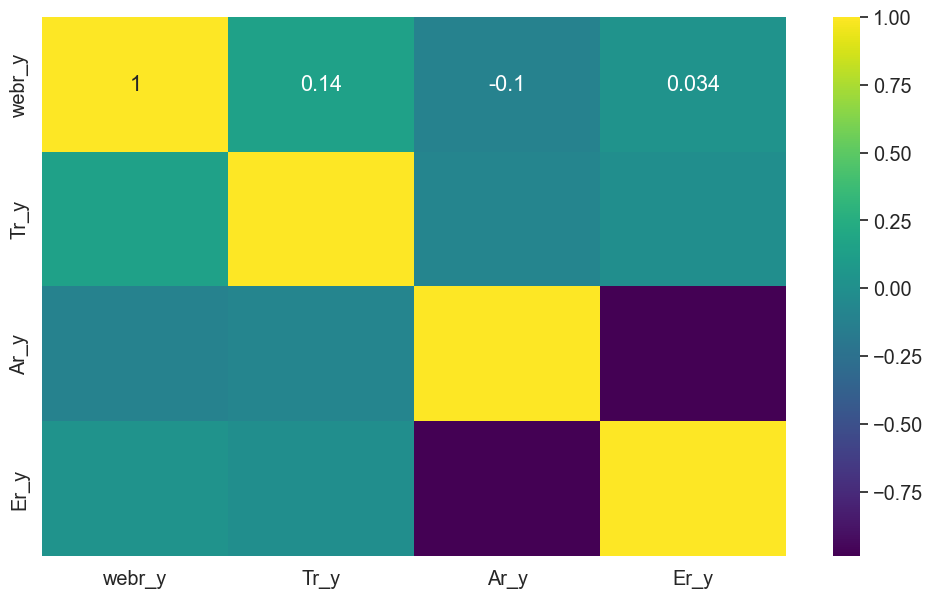

In [28]:
corr_matrix = df_metrics[['webr_y', 'Tr_y', 'Ar_y', 'Er_y']].corr()

sns.set(font_scale=1.3)

f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')

C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

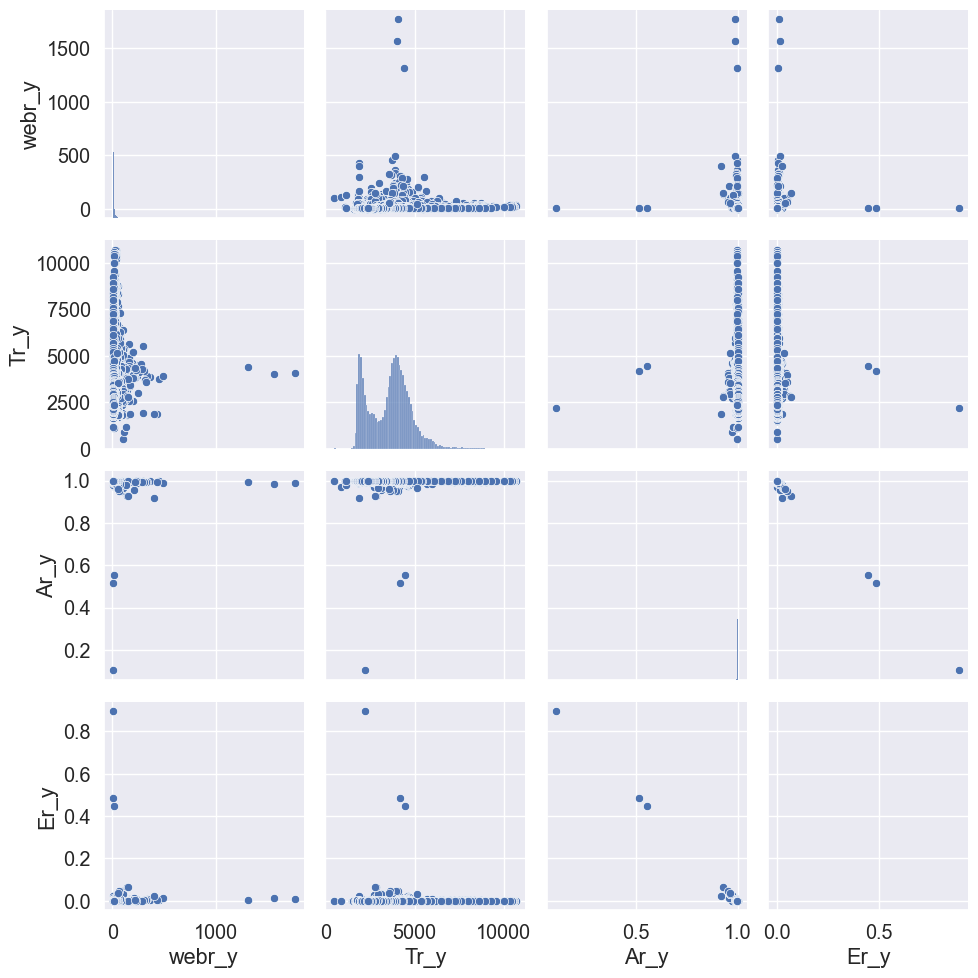

In [29]:
sns.pairplot(df_metrics[['webr_y', 'Tr_y', 'Ar_y', 'Er_y']])

In [ ]:
data = grouped_webr[['point', 'webr_y']]

In [ ]:
# Load your time series data
# Replace 'your_time_series.csv' with your actual file
# Ensure the CSV has a column 'timestamp' for timestamps and 'response_time' for response times
df = pd.read_csv('your_time_series.csv', parse_dates=['timestamp'])

# Set the timestamp as the index
df.set_index('timestamp', inplace=True)

# Feature Engineering
# You can create various features like moving averages, rolling std, etc.
df['rolling_mean'] = df['response_time'].rolling(window=10).mean()
df['rolling_std'] = df['response_time'].rolling(window=10).std()
df['response_diff'] = df['response_time'].diff()

# Drop any rows with NaN values that resulted from feature creation
df.dropna(inplace=True)

# Use the features for Isolation Forest
features = df[['response_time', 'rolling_mean', 'rolling_std', 'response_diff']]

# Train Isolation Forest
model = IsolationForest(contamination=0.01)  # Adjust contamination as needed
model.fit(features)

# Detect anomalies
df['anomaly_score'] = model.decision_function(features)
df['anomaly'] = model.predict(features)

# Anomalies are labeled as -1, normal as 1
df['anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['response_time'], label='Response Time')
plt.scatter(
	df.index[df['anomaly'] == 1],
	df['response_time'][df['anomaly'] == 1],
	color='red',
	label='Anomaly',
)
plt.xlabel('Timestamp')
plt.ylabel('Response Time')
plt.title('Web Response Time with Anomalies')
plt.legend()
plt.show()